In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Input, Multiply, Reshape, Add, GlobalAveragePooling2D, GlobalMaxPooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
sns.set()
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set up directories
data1_directory = pathlib.Path(r'C:\Users\azadh\Desktop\IP\fruit-images\valid')
data2_directory = pathlib.Path(r'C:\Users\azadh\Desktop\IP\fruit-images\train')

In [3]:
# Debug: Check if directories exist
print("Valid directory exists:", data1_directory.exists())
print("Train directory exists:", data2_directory.exists())

# Get class names
class_names = sorted([item.name for item in data2_directory.iterdir() if item.is_dir()])
print("Class Names:", class_names)

# Count images in each category
def count_images(directory):
    counts = {}
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
        else:
            print(f"Warning: Directory {class_dir} does not exist!")
            counts[class_name] = 0
    return counts

valid_counts = count_images(r'C:\Users\azadh\Desktop\IP\fruit-images\valid')
train_counts = count_images(r'C:\Users\azadh\Desktop\IP\fruit-images\train')

print("Valid Image Counts:", valid_counts)
print("Train Image Counts:", train_counts)

Valid directory exists: True
Train directory exists: True
Class Names: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
Valid Image Counts: {'Apple': 40, 'Banana': 40, 'Grape': 40, 'Mango': 40, 'Strawberry': 40}
Train Image Counts: {'Apple': 1940, 'Banana': 1940, 'Grape': 1940, 'Mango': 1942, 'Strawberry': 1940}


In [4]:
# Data Generators
data_gen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

train_data = data_gen.flow_from_directory(
    data2_directory, 
    target_size=(224, 224), 
    batch_size=32, 
    subset='training', 
    class_mode='sparse'
)

val_data = data_gen.flow_from_directory(
    data2_directory, 
    target_size=(224, 224), 
    batch_size=32, 
    subset='validation', 
    class_mode='sparse'
)


Found 7762 images belonging to 5 classes.
Found 1940 images belonging to 5 classes.


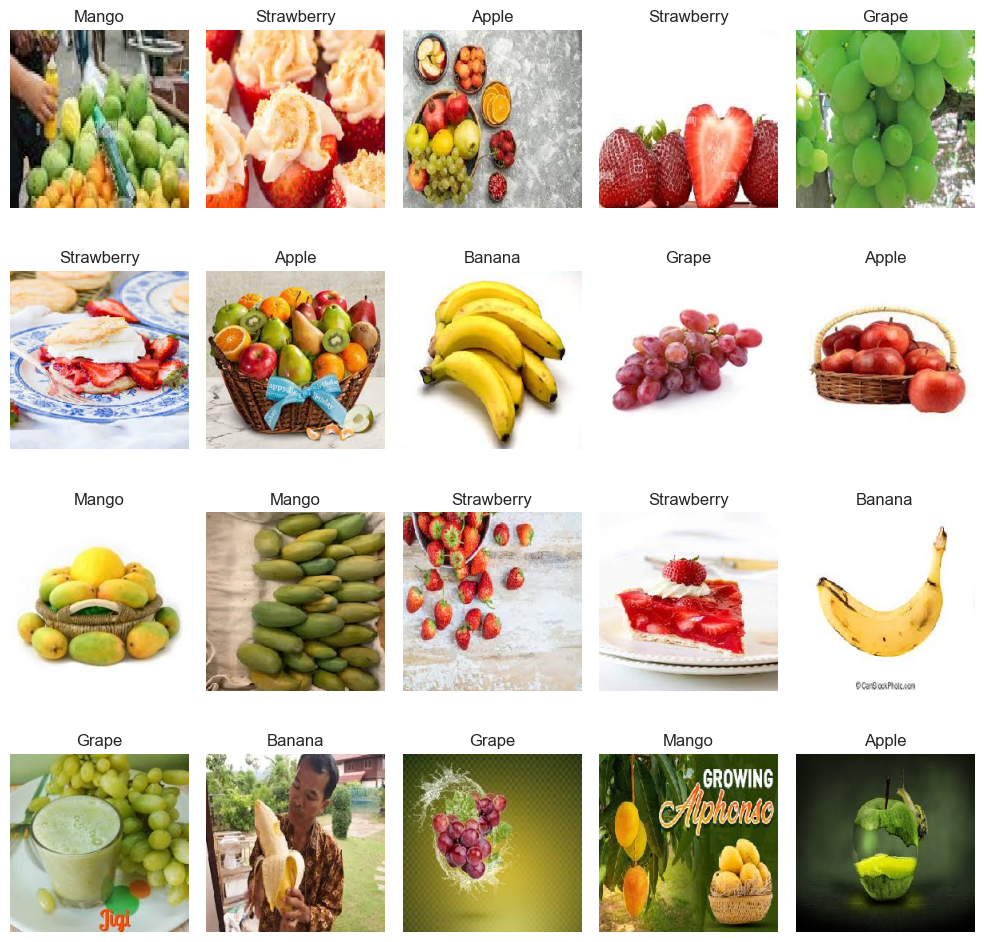

In [5]:
# Plot Random Images
def plot_random_images():
    images, labels = next(train_data)
    labels = labels.astype('int32')
    plt.figure(figsize=(10, 10))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_random_images()

In [6]:
# Attention Module
def attention_module(input_tensor):
    """
    Implements a basic Channel and Spatial Attention mechanism.
    """
    # Channel Attention
    channel_avg = GlobalAveragePooling2D()(input_tensor)
    channel_avg = Dense(input_tensor.shape[-1] // 8, activation='relu')(channel_avg)
    channel_avg = Dense(input_tensor.shape[-1], activation='sigmoid')(channel_avg)
    channel_attention = Multiply()([input_tensor, Reshape((1, 1, input_tensor.shape[-1]))(channel_avg)])

    # Spatial Attention
    spatial_avg = GlobalAveragePooling2D(keepdims=True)(input_tensor)
    spatial_max = GlobalMaxPooling2D(keepdims=True)(input_tensor)
    spatial_attention = Conv2D(1, (7, 7), padding="same", activation="sigmoid")(Add()([spatial_avg, spatial_max]))

    # Combine both attentions
    attention_output = Multiply()([channel_attention, spatial_attention])
    return attention_output

In [7]:
# CNN with Attention
def cnn_with_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    # Add Attention
    x = attention_module(x)

    # Second Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Add Attention
    x = attention_module(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

In [8]:
# Model Setup
input_shape = (224, 224, 3)
num_classes = len(class_names)
model = cnn_with_attention(input_shape, num_classes)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 224, 224, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 112, 112, 32)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 32)                │               0 │ max_pooling2d[0][0]        │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 4)                 │             132 │ global_average_pooling2d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 32)                │             160 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_1    │ (None, 1, 1, 32)          │               0 │ max_pooling2d[0][0]        │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d          │ (None, 1, 1, 32)          │               0 │ max_pooling2d[0][0]        │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 1, 32)          │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 1, 1, 32)          │               0 │ global_average_pooling2d_… │
│                               │                           │                 │ global_max_pooling2d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 112, 112, 32)      │               0 │ max_pooling2d[0][0],       │
│                               │                           │                 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 1, 1, 1)           │           1,569 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_1 (Multiply)         │ (None, 112, 112, 32)      │               0 │ multiply[0][0],            │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 112, 112, 64)      │          18,496 │ multiply_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,716,371 (98.10 MB)

 Trainable params: 25,716,371 (98.10 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)


In [10]:
# Train the Model
classifier = model.fit(
    train_data, 
    validation_data=val_data, 
    epochs=22, 
    batch_size=32, 
    verbose=1, 
    callbacks=[reduce_lr]
)


Epoch 1/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.3885 - loss: 1.3833 - val_accuracy: 0.4773 - val_loss: 1.2378 - learning_rate: 0.0010
Epoch 2/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.6051 - loss: 0.9878 - val_accuracy: 0.5165 - val_loss: 1.1336 - learning_rate: 0.0010
Epoch 3/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.7048 - loss: 0.7886 - val_accuracy: 0.5675 - val_loss: 1.0882 - learning_rate: 0.0010
Epoch 4/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.8225 - loss: 0.4916 - val_accuracy: 0.5526 - val_loss: 1.3827 - learning_rate: 0.0010
Epoch 5/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9244 - loss: 0.2251 - val_accuracy: 0.5206 - val_loss: 2.1221 - learning_rate: 0.0010
Epoch 6/22

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
243/243 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.9564 - loss: 0.1406 - val_accuracy: 0.5608 - val_loss: 2.2543 - learning_rate: 0.0010
Epoch

In [11]:
# Evaluate the Model
model.evaluate(val_data)

61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.5539 - loss: 4.4680


[4.607333660125732, 0.5484536290168762]

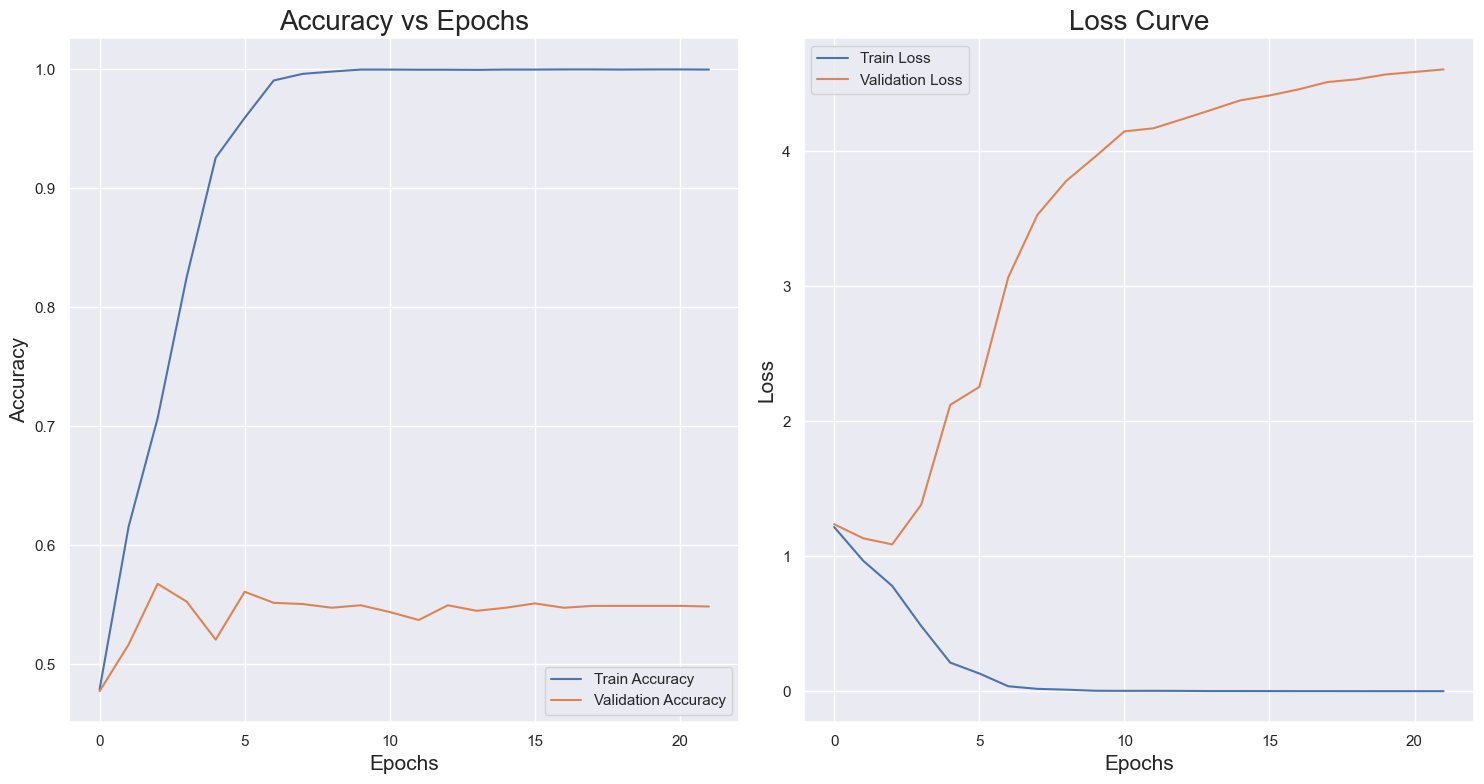

In [12]:
# Model Performance Graphs
def model_performance_graphs():
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    
    # Accuracy
    axes[0].plot(classifier.epoch, classifier.history['accuracy'], label='Train Accuracy')
    axes[0].plot(classifier.epoch, classifier.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Accuracy vs Epochs', fontsize=20)
    axes[0].set_xlabel('Epochs', fontsize=15)
    axes[0].set_ylabel('Accuracy', fontsize=15)
    axes[0].legend()

    # Loss
    axes[1].plot(classifier.epoch, classifier.history['loss'], label='Train Loss')
    axes[1].plot(classifier.epoch, classifier.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Loss Curve', fontsize=20)
    axes[1].set_xlabel('Epochs', fontsize=15)
    axes[1].set_ylabel('Loss', fontsize=15)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

model_performance_graphs()

In [13]:
# Generate predictions for the validation dataset
val_predictions = model.predict(val_data)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# True labels for the validation dataset
true_classes = val_data.classes

# Class names (in the same order as the dataset generator)
class_labels = list(val_data.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, val_predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step
Classification Report:
              precision    recall  f1-score   support

       Apple       0.20      0.23      0.21       388
      Banana       0.18      0.17      0.18       388
       Grape       0.20      0.19      0.19       388
       Mango       0.20      0.18      0.19       388
  Strawberry       0.17      0.17      0.17       388

    accuracy                           0.19      1940
   macro avg       0.19      0.19      0.19      1940
weighted avg       0.19      0.19      0.19      1940



In [14]:
# Save and Load Model
model.save('model_with_attention_v2.keras')
loaded_model = tf.keras.models.load_model('model_with_attention_v2.keras', custom_objects={'attention_module': attention_module})

In [15]:
# Preprocess Images
def preprocess_images(path):
    img = image.load_img(path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_array / 255.0
    return img_preprocessed

In [16]:
# Test Prediction
img_path = r"C:\Users\azadh\Desktop\IP\fruit-images\from-google\m1.jpg"
img = preprocess_images(img_path)
prediction = loaded_model.predict(img)

predicted_class_index = np.argmax(prediction)
predicted_class_label = class_names[predicted_class_index]

print("Predicted class with attention:", predicted_class_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Predicted class with attention: Mango
